## This is the notebook to use for evaluating a novel dataset. Please replace the randomly sampled dataframe with the test csv

# 1. Load Data and perform basic operations

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
deloitte_data_filename = 'Deloitte_DrugDiscovery_dataset.csv'

In [4]:
kiba_df = pd.read_csv(deloitte_data_filename)


In [26]:
test_df = kiba_df.sample(5000)

In [27]:
test_df.shape

(5000, 4)

In [28]:
test_df.head()

,UniProt_ID,pubchem_cid,kiba_score,kiba_score_estimated
360586,P13866,71454962.0,88.90,True
536177,P29274,162647388.0,149.00,True
826911,P56817,58197275.0,760.00,True
1086350,Q9NYW2,53374185.0,38.80,True
372934,P14920,117693422.0,6.21,True


## replace test_df with a proper evaluation set!

### drop any rows with NA's - not too many

In [29]:
test_df = test_df.dropna()
# i hope the test set won't have any NAs 

### for any cases where same UniProtID and pubchem_cid is associated with multiple kiba scores, lets take the mean

In [30]:
# test_df = test_df.groupby(['UniProt_ID', 'pubchem_cid'], as_index=False).mean() 
# skip this test in test mode

In [31]:
test_df.shape

(4827, 4)

In [32]:
test_df.head()

,UniProt_ID,pubchem_cid,kiba_score,kiba_score_estimated
360586,P13866,71454962.0,88.90,True
536177,P29274,162647388.0,149.00,True
826911,P56817,58197275.0,760.00,True
1086350,Q9NYW2,53374185.0,38.80,True
372934,P14920,117693422.0,6.21,True


In [33]:
unique_protein_ids = test_df.UniProt_ID.unique().tolist()

In [34]:
len(unique_protein_ids)

1225

In [35]:
unique_chemical_ids = test_df.pubchem_cid.unique().astype(int).astype(str).tolist()

In [36]:
len(unique_chemical_ids)

4754

# 2. Query useful features from pubchem 

In [37]:
import requests
from io import StringIO
import xml.etree.ElementTree as ET


First, we put together a list of potentially useful features. I dug up the pubchem API and basically looked at all available numerical features that seem useful, as well as CanonicalSMILES. I kind of forgot molecular weight, but there are several other features that convey the same thing (i.e. ExactMAss)

In [38]:

needed_props = ['CanonicalSMILES','XLogP',
       'ExactMass', 'MonoisotopicMass', 'TPSA', 'Complexity', 'Charge',
       'HBondDonorCount', 'HBondAcceptorCount', 'RotatableBondCount',
       'HeavyAtomCount', 'IsotopeAtomCount', 'AtomStereoCount',
       'DefinedAtomStereoCount', 'UndefinedAtomStereoCount', 'BondStereoCount',
       'DefinedBondStereoCount', 'UndefinedBondStereoCount',
       'CovalentUnitCount', 'PatentCount', 'PatentFamilyCount',
       'LiteratureCount', 'Volume3D', 'XStericQuadrupole3D',
       'YStericQuadrupole3D', 'ZStericQuadrupole3D', 'FeatureCount3D',
       'FeatureAcceptorCount3D', 'FeatureDonorCount3D', 'FeatureAnionCount3D',
       'FeatureCationCount3D', 'FeatureRingCount3D',
       'FeatureHydrophobeCount3D', 'ConformerModelRMSD3D',
       'EffectiveRotorCount3D', 'ConformerCount3D']

### this function returns a list of query results from pubchem db RATE_LIMIT entries at a time. I found that I needed to query chem IDS in batches, as otherwise the URL would be too long.

### even still, for all 600k+ chem IDs I need to query, this function took a few hours to run. 

In [45]:
def return_pubchem_features_listkey(props, chem_ids):
    # https://pubchem.ncbi.nlm.nih.gov/docs/pug-rest#section=Synonyms
    RATE_LIMIT = 400
    total_features = []
    for i in range(len(chem_ids)//RATE_LIMIT + 1):
        print(f'doing nums {i*RATE_LIMIT} to {(i+1)*RATE_LIMIT}')
        start_range = i*RATE_LIMIT
        end_range = min([(i+1)*RATE_LIMIT, len(chem_ids)])
        url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(chem_ids[start_range:end_range])}/cids/XML?list_return=listkey'
        response = requests.post(url)
        print('response: ',response)
        root = ET.fromstring(response.text)
        
        
        # Define the namespace
        namespace = {"ns": "http://pubchem.ncbi.nlm.nih.gov/pug_rest"}
        
        # Find and retrieve the ListKey value
        listkey = root.find("ns:ListKey", namespaces=namespace).text
        print("ListKey:", listkey)
        property_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{listkey}/property/{props}/CSV"
        
        # Make a GET request to retrieve the properties
        property_response = requests.get(property_url)
        print('property response: ',property_response)
        features = pd.read_csv(StringIO(property_response.text))
        total_features.append(features)
        #time.sleep(1)
    return total_features

In [46]:
chem_features_queried = return_pubchem_features_listkey(','.join(needed_props), unique_chemical_ids)

doing nums 0 to 400
response:  <Response [200]>
ListKey: 2292000322943216395
property response:  <Response [200]>
doing nums 400 to 800
response:  <Response [200]>
ListKey: 3068624566235416437
property response:  <Response [200]>
doing nums 800 to 1200
response:  <Response [200]>
ListKey: 3533008235948766268
property response:  <Response [200]>
doing nums 1200 to 1600
response:  <Response [200]>
ListKey: 2746745876981508978
property response:  <Response [200]>
doing nums 1600 to 2000
response:  <Response [200]>
ListKey: 1654947154035404836
property response:  <Response [200]>
doing nums 2000 to 2400
response:  <Response [200]>
ListKey: 1777772352588886156
property response:  <Response [200]>
doing nums 2400 to 2800
response:  <Response [200]>
ListKey: 4587142669344764766
property response:  <Response [200]>
doing nums 2800 to 3200
response:  <Response [200]>
ListKey: 1006199621158684614
property response:  <Response [200]>
doing nums 3200 to 3600
response:  <Response [200]>
ListKey: 36

In [47]:
chem_features_df = pd.concat(chem_features_queried)

In [48]:
chem_features_df.head()

,CID,CanonicalSMILES,XLogP,ExactMass,MonoisotopicMass,TPSA,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,...,FeatureCount3D,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D
0,71454962,CCC1=CC=C(C=C1)CC2=C(NN=C2OC3C(C(C(C(O3)CO)O)O...,2.3,406.210387,406.210387,128.0,502.0,0,5,7,...,15.0,5.0,5.0,0.0,0.0,3.0,2.0,1.0,8.2,10
1,162647388,CN1C=C2C(=N1)N=C(N3C2=NC(=N3)C4=CC=CO4)NC(=O)N...,3.6,1024.317388,1024.317388,309.0,2060.0,0,6,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,58197275,COC1CCC2(CC1)CC3=C(C24CCSC(=N4)N)C=C(C=C3)Br,3.6,394.071450,394.071450,72.9,491.0,0,1,3,...,8.0,1.0,1.0,0.0,1.0,4.0,1.0,0.6,2.8,10
3,53374185,CC1=C(C(=NO1)C)CN2C=C(C=N2)N3C(=O)C(N(C3=O)CC4...,1.8,418.175339,418.175339,108.0,764.0,0,0,6,...,10.0,5.0,0.0,0.0,0.0,4.0,1.0,1.0,5.6,10
4,117693422,CC(C)(C)C1=CC=C(C=C1)CCC2=CC(=O)C(=O)NN2,3.5,272.152478,272.152478,58.2,413.0,0,2,3,...,7.0,2.0,2.0,0.0,0.0,2.0,1.0,0.6,4.0,10


In [51]:
# if there is a timeout, you get this funky thing happen
if 'Status: 504' in chem_features_df.columns:
    chem_features_df = chem_features_df.drop(columns=['Status: 504'])

In [50]:
chem_features_df.shape

(4754, 37)

### in the end, i did not end up using a version of my workflow where i attempted to extract additional features from CanonicalSMILES - it was just too slow on my laptop

In [52]:
chem_features_df = chem_features_df.drop(columns=['CanonicalSMILES'])

In [53]:
chem_features_df.shape

(4754, 36)

# 3. Query protein DB and obtain additional protein features from sequence

Needed a slightly different strategy for querying proteins. I decided to get the sequence, mass, length, annotation score and feature count

In [54]:
def query_uniprot_features(uniprot_ids):
    # Join IDs into a single query string
    query = " OR ".join(uniprot_ids)
    
    # Define the UniProt API endpoint
    url = "https://rest.uniprot.org/uniprotkb/search"
    
    # Define the fields you want to retrieve
    fields = "mass,sequence,length,feature_count,annotation_score"
    
    # Parameters for the API call
    params = {
        "query": query,
        "fields": fields,
        "format": "json",
        "size": len(uniprot_ids)  # Number of records to return
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    response.raise_for_status()
    # Print the response JSON to check its structure

# Print the columns in the DataFrame
    # Parse JSON response into a DataFrame
    data = response.json()["results"]
    df = pd.json_normalize(data)
    # Optional: Rename columns for easier readability
    
    return df

Once again, in order to avoid slamming the server we have to do it a little bit at a time. This function just calls the above one for 100 proteins at a time

In [55]:
def return_uniprot_features(prot_ids):
    RATE_LIMIT = 100
    total_features = []
    for i in range(len(prot_ids)//RATE_LIMIT + 1):
        print(f'doing nums {i*RATE_LIMIT} to {(i+1)*RATE_LIMIT}')
        start_range = i*RATE_LIMIT
        end_range = min([(i+1)*RATE_LIMIT, len(prot_ids)])
        features = query_uniprot_features(prot_ids[start_range:end_range])
        total_features.append(features)
    return total_features

In [56]:
prot_features = return_uniprot_features(unique_protein_ids)

doing nums 0 to 100
doing nums 100 to 200
doing nums 200 to 300
doing nums 300 to 400
doing nums 400 to 500
doing nums 500 to 600
doing nums 600 to 700
doing nums 700 to 800
doing nums 800 to 900
doing nums 900 to 1000
doing nums 1000 to 1100
doing nums 1100 to 1200
doing nums 1200 to 1300


In [57]:
prot_features_df = pd.concat(prot_features)

In [58]:
prot_features_df.head()

,entryType,primaryAccession,annotationScore,sequence.value,sequence.length,sequence.molWeight,sequence.crc64,sequence.md5,extraAttributes.countByFeatureType.Chain,extraAttributes.countByFeatureType.Topological domain,...,extraAttributes.countByFeatureType.Compositional bias,extraAttributes.countByFeatureType.Propeptide,extraAttributes.countByFeatureType.Site,extraAttributes.countByFeatureType.Intramembrane,extraAttributes.countByFeatureType.Zinc finger,extraAttributes.countByFeatureType.Repeat,extraAttributes.countByFeatureType.Transit peptide,extraAttributes.countByFeatureType.DNA binding,extraAttributes.countByFeatureType.Peptide,extraAttributes.countByFeatureType.Non-terminal residue
0,UniProtKB reviewed (Swiss-Prot),P29274,5.0,MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVV...,412,44707,9438E9D64A6BE61B,7729B3238384B417C4D5CFF9E8F6A4A1,1.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UniProtKB reviewed (Swiss-Prot),P30542,5.0,MPPSISAFQAAYIGIEVLIALVSVPGNVLVIWAVKVNQALRDATFC...,326,36512,1B555893BCDEC9A6,660A39956B645714DDD62FF8B4550418,1.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UniProtKB reviewed (Swiss-Prot),Q9UHD2,5.0,MQSTSNHLWLLSDILGQGATANVFRGRHKKTGDLFAIKVFNNISFL...,729,83642,B58E4FE1B502276D,EA019CF79D039A451DECE6C8A25E0050,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,UniProtKB reviewed (Swiss-Prot),P27361,5.0,MAAAAAQGGGGGEPRRTEGVGPGVPGEVEMVKGQPFDVGPRYTQLQ...,379,43136,E6020CE413EC41F7,8501FAF469E77A9FBDC0166F5A18BCF6,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,UniProtKB reviewed (Swiss-Prot),P43405,5.0,MASSGMADSANHLPFFFGNITREEAEDYLVQGGMSDGLYLLRQSRN...,635,72066,EAA6BDE65881FC68,17DBD30C3A3CCB7420537914A95D3F54,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


since some of the extraAttributes features may not be exposed for a given set of proteins, i need to make sure that all the ones I am expecting from the full dataset are there. In this case, i only see 41 columns but I know there should be 45 for the full version

In [59]:
expected_protein_query_columns = ['primaryAccession', 'annotationScore', 'sequence.value',
       'sequence.length', 'sequence.molWeight',
       'extraAttributes.countByFeatureType.Chain',
       'extraAttributes.countByFeatureType.Topological domain',
       'extraAttributes.countByFeatureType.Transmembrane',
       'extraAttributes.countByFeatureType.Region',
       'extraAttributes.countByFeatureType.Binding site',
       'extraAttributes.countByFeatureType.Glycosylation',
       'extraAttributes.countByFeatureType.Disulfide bond',
       'extraAttributes.countByFeatureType.Natural variant',
       'extraAttributes.countByFeatureType.Helix',
       'extraAttributes.countByFeatureType.Beta strand',
       'extraAttributes.countByFeatureType.Turn',
       'extraAttributes.countByFeatureType.Lipidation',
       'extraAttributes.countByFeatureType.Initiator methionine',
       'extraAttributes.countByFeatureType.Domain',
       'extraAttributes.countByFeatureType.Active site',
       'extraAttributes.countByFeatureType.Modified residue',
       'extraAttributes.countByFeatureType.Alternative sequence',
       'extraAttributes.countByFeatureType.Mutagenesis',
       'extraAttributes.countByFeatureType.Signal',
       'extraAttributes.countByFeatureType.Motif',
       'extraAttributes.countByFeatureType.Compositional bias',
       'extraAttributes.countByFeatureType.Sequence conflict',
       'extraAttributes.countByFeatureType.Site',
       'extraAttributes.countByFeatureType.Zinc finger',
       'extraAttributes.countByFeatureType.Coiled coil',
       'extraAttributes.countByFeatureType.Cross-link',
       'extraAttributes.countByFeatureType.DNA binding',
       'extraAttributes.countByFeatureType.Repeat',
       'extraAttributes.countByFeatureType.Propeptide',
       'extraAttributes.countByFeatureType.Transit peptide',
       'extraAttributes.countByFeatureType.Peptide',
       'extraAttributes.countByFeatureType.Intramembrane',
       'extraAttributes.countByFeatureType.Non-terminal residue',
       'extraAttributes.countByFeatureType.Non-standard residue',
       'extraAttributes.countByFeatureType.Non-adjacent residues',
       'extraAttributes.countByFeatureType.Sequence uncertainty']

In [60]:
for colname in expected_protein_query_columns:
    if colname not in prot_features_df.columns:
        prot_features_df[colname] = 0

In [61]:
prot_features_df.shape

(1225, 45)

however we don't actually need some of the string features

In [62]:
prot_features_df = prot_features_df.drop(columns=['entryType',  'sequence.crc64', 'sequence.md5', 'extraAttributes.uniParcId'])

In [63]:
prot_features_df.shape

(1225, 41)

## 3.1 use biopython to extract additional sequence features 
I was originally hoping I would have the time and resources to do something fancy with the sequence, such as protBERT embeddings or at least some kmer-based features. However, I must admit I have a humble 2019 macbook and it was just too slow to extract the features, and I don't quite have the capacity to train a powerful model from those features anyway.

Anyway, I revert to BioPython ProteinAnalaysis package

In [64]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis


In [65]:
def extract_sequence_features(sequence):
    stripped_sequence = sequence.replace('U','').replace('X', '').replace('B', 'N').replace('Z', 'Q') 
    # this is not ideal, but a few weird protein sequences break the biopython function. 
    # https://www.genome.jp/kegg/tables/br08081.html - my resource to tell me how to best replace the off-kilter amino acids
    analysis = ProteinAnalysis(stripped_sequence)
    
    # Physicochemical descriptors
    
    aa_composition = analysis.get_amino_acids_percent()
    molecular_weight = analysis.molecular_weight()
    pI = analysis.isoelectric_point()
    aromaticity = analysis.aromaticity()
    instability_index = analysis.instability_index()
    gravy = analysis.gravy()
    sec_struct_fraction = analysis.secondary_structure_fraction()
    return_dict = aa_composition
    return_dict['protein_seq_molecular_weight'] = molecular_weight
    return_dict['protein_seq_pI'] = pI
    return_dict['protein_seq_aromaticity'] = aromaticity
    return_dict['protein_seq_instability_index'] = instability_index
    return_dict['protein_seq_gravy'] = gravy
    return_dict['protein_seq_struct_fraction_helix'] = sec_struct_fraction[0]
    return_dict['protein_seq_struct_fraction_turn'] = sec_struct_fraction[1]
    return_dict['protein_seq_struct_fraction_sheet'] = sec_struct_fraction[2]
    return return_dict

In [66]:
sequence_features = prot_features_df['sequence.value'].apply(lambda x: extract_sequence_features(x))

In [67]:
protein_seq_features_df = pd.DataFrame(sequence_features.values.tolist())

In [68]:
protein_seq_features_df.shape

(1225, 28)

In [69]:
protein_seq_features_df.head()

,A,C,D,E,F,G,H,I,K,L,...,W,Y,protein_seq_molecular_weight,protein_seq_pI,protein_seq_aromaticity,protein_seq_instability_index,protein_seq_gravy,protein_seq_struct_fraction_helix,protein_seq_struct_fraction_turn,protein_seq_struct_fraction_sheet
0,0.101942,0.036408,0.021845,0.036408,0.048544,0.082524,0.026699,0.070388,0.021845,0.121359,...,0.016990,0.026699,44706.8798,8.335069,0.092233,39.562864,0.460680,0.368932,0.247573,0.279126
1,0.098160,0.027607,0.027607,0.033742,0.058282,0.036810,0.015337,0.095092,0.046012,0.125767,...,0.021472,0.036810,36511.3425,8.904067,0.116564,40.953405,0.700307,0.435583,0.196319,0.285276
2,0.049383,0.015089,0.046639,0.089163,0.038409,0.057613,0.035665,0.067215,0.075446,0.105624,...,0.009602,0.038409,83641.1580,6.319439,0.086420,45.703717,-0.347188,0.320988,0.189300,0.274348
3,0.068602,0.015831,0.058047,0.068602,0.034301,0.063325,0.029024,0.068602,0.055409,0.113456,...,0.007916,0.047493,43135.0670,6.280447,0.089710,43.062797,-0.313984,0.319261,0.203166,0.277045
4,0.070866,0.014173,0.042520,0.075591,0.029921,0.078740,0.029921,0.040945,0.077165,0.094488,...,0.017323,0.053543,72065.3676,8.431965,0.100787,40.852126,-0.537480,0.292913,0.237795,0.270866


Now to combine sequence features with other queried features:

In [70]:
prot_features_combined_df = pd.concat([prot_features_df.reset_index(drop=True), protein_seq_features_df], axis=1)

In [71]:
prot_features_combined_df.loc[0]

primaryAccession                                                                P29274
annotationScore                                                                    5.0
sequence.value                       MPIMGSSVYITVELAIAVLAILGNVLVCWAVWLNSNLQNVTNYFVV...
sequence.length                                                                    412
sequence.molWeight                                                               44707
                                                           ...                        
protein_seq_instability_index                                                39.562864
protein_seq_gravy                                                              0.46068
protein_seq_struct_fraction_helix                                             0.368932
protein_seq_struct_fraction_turn                                              0.247573
protein_seq_struct_fraction_sheet                                             0.279126
Name: 0, Length: 69, dtype: object

We can drop sequence now, and rename primaryAccession back to UniProt_ID

In [72]:
prot_features_combined_df = prot_features_combined_df.drop(columns=['sequence.value']).rename(columns={'primaryAccession': 'UniProt_ID'})

In [73]:
prot_features_combined_df.head()

,UniProt_ID,annotationScore,sequence.length,sequence.molWeight,extraAttributes.countByFeatureType.Chain,extraAttributes.countByFeatureType.Topological domain,extraAttributes.countByFeatureType.Transmembrane,extraAttributes.countByFeatureType.Region,extraAttributes.countByFeatureType.Binding site,extraAttributes.countByFeatureType.Glycosylation,...,W,Y,protein_seq_molecular_weight,protein_seq_pI,protein_seq_aromaticity,protein_seq_instability_index,protein_seq_gravy,protein_seq_struct_fraction_helix,protein_seq_struct_fraction_turn,protein_seq_struct_fraction_sheet
0,P29274,5.0,412,44707,1.0,8.0,7.0,1.0,4.0,1.0,...,0.016990,0.026699,44706.8798,8.335069,0.092233,39.562864,0.460680,0.368932,0.247573,0.279126
1,P30542,5.0,326,36512,1.0,8.0,7.0,NaN,NaN,1.0,...,0.021472,0.036810,36511.3425,8.904067,0.116564,40.953405,0.700307,0.435583,0.196319,0.285276
2,Q9UHD2,5.0,729,83642,1.0,NaN,NaN,1.0,2.0,NaN,...,0.009602,0.038409,83641.1580,6.319439,0.086420,45.703717,-0.347188,0.320988,0.189300,0.274348
3,P27361,5.0,379,43136,1.0,NaN,NaN,1.0,2.0,NaN,...,0.007916,0.047493,43135.0670,6.280447,0.089710,43.062797,-0.313984,0.319261,0.203166,0.277045
4,P43405,5.0,635,72066,1.0,NaN,NaN,2.0,2.0,NaN,...,0.017323,0.053543,72065.3676,8.431965,0.100787,40.852126,-0.537480,0.292913,0.237795,0.270866


In [74]:
prot_features_combined_df.head()

,UniProt_ID,annotationScore,sequence.length,sequence.molWeight,extraAttributes.countByFeatureType.Chain,extraAttributes.countByFeatureType.Topological domain,extraAttributes.countByFeatureType.Transmembrane,extraAttributes.countByFeatureType.Region,extraAttributes.countByFeatureType.Binding site,extraAttributes.countByFeatureType.Glycosylation,...,W,Y,protein_seq_molecular_weight,protein_seq_pI,protein_seq_aromaticity,protein_seq_instability_index,protein_seq_gravy,protein_seq_struct_fraction_helix,protein_seq_struct_fraction_turn,protein_seq_struct_fraction_sheet
0,P29274,5.0,412,44707,1.0,8.0,7.0,1.0,4.0,1.0,...,0.016990,0.026699,44706.8798,8.335069,0.092233,39.562864,0.460680,0.368932,0.247573,0.279126
1,P30542,5.0,326,36512,1.0,8.0,7.0,NaN,NaN,1.0,...,0.021472,0.036810,36511.3425,8.904067,0.116564,40.953405,0.700307,0.435583,0.196319,0.285276
2,Q9UHD2,5.0,729,83642,1.0,NaN,NaN,1.0,2.0,NaN,...,0.009602,0.038409,83641.1580,6.319439,0.086420,45.703717,-0.347188,0.320988,0.189300,0.274348
3,P27361,5.0,379,43136,1.0,NaN,NaN,1.0,2.0,NaN,...,0.007916,0.047493,43135.0670,6.280447,0.089710,43.062797,-0.313984,0.319261,0.203166,0.277045
4,P43405,5.0,635,72066,1.0,NaN,NaN,2.0,2.0,NaN,...,0.017323,0.053543,72065.3676,8.431965,0.100787,40.852126,-0.537480,0.292913,0.237795,0.270866


In [75]:
prot_features_combined_df.shape

(1225, 68)

# 4. Mix things together and final preparation before we do modeling

In [76]:
combined_kiba_prot_df = test_df.merge(prot_features_combined_df, how='inner', on='UniProt_ID')

In [77]:
combined_kiba_prot_df.shape

(4827, 71)

In [78]:
combined_kiba_prot_df['pubchem_cid'] = combined_kiba_prot_df['pubchem_cid'].astype(int)

In [79]:
chem_features_df = chem_features_df.rename(columns={'CID': 'pubchem_cid'})

In [80]:
combined_kiba_prot_chem_df = combined_kiba_prot_df.merge(chem_features_df, how='inner', on='pubchem_cid')

In [81]:
combined_kiba_prot_chem_df.shape

(4827, 106)

In [82]:
combined_kiba_prot_chem_df.head()

,UniProt_ID,pubchem_cid,kiba_score,kiba_score_estimated,annotationScore,sequence.length,sequence.molWeight,extraAttributes.countByFeatureType.Chain,extraAttributes.countByFeatureType.Topological domain,extraAttributes.countByFeatureType.Transmembrane,...,FeatureCount3D,FeatureAcceptorCount3D,FeatureDonorCount3D,FeatureAnionCount3D,FeatureCationCount3D,FeatureRingCount3D,FeatureHydrophobeCount3D,ConformerModelRMSD3D,EffectiveRotorCount3D,ConformerCount3D
0,P13866,71454962,88.90,True,5.0,664,73498,1.0,14.0,13.0,...,15.0,5.0,5.0,0.0,0.0,3.0,2.0,1.0,8.2,10
1,P29274,162647388,149.00,True,5.0,412,44707,1.0,8.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,P56817,58197275,760.00,True,5.0,501,55764,1.0,2.0,1.0,...,8.0,1.0,1.0,0.0,1.0,4.0,1.0,0.6,2.8,10
3,Q9NYW2,53374185,38.80,True,4.0,309,35877,1.0,8.0,7.0,...,10.0,5.0,0.0,0.0,0.0,4.0,1.0,1.0,5.6,10
4,P14920,117693422,6.21,True,5.0,347,39474,1.0,NaN,NaN,...,7.0,2.0,2.0,0.0,0.0,2.0,1.0,0.6,4.0,10


## Fill in 0 for all NA values - makes the model work better!

In [108]:
combined_kiba_prot_chem_df = combined_kiba_prot_chem_df.fillna(0)

/var/folders/nm/yslfs0f104n0qtsyntj9vnq80000gn/T/ipykernel_13120/3060224436.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_kiba_prot_chem_df = combined_kiba_prot_chem_df.fillna(0)


### as mentioned in the presentation, I think it makes more sense to predict log_kiba since it is normally distributred. unlike the raw values which are highlyt clsutered 

In [109]:
y = np.log(combined_kiba_prot_chem_df['kiba_score'])

In [110]:
X = combined_kiba_prot_chem_df.drop(columns=['pubchem_cid', 'UniProt_ID', 'kiba_score'])

## for evaluation only - since XGBoost likes matrices instead of dataframes, I need to make sure columns are ordered exactly the same way as for my trained model

In [111]:
correct_column_order = ['kiba_score_estimated', 'annotationScore', 'sequence.length',
       'sequence.molWeight', 'extraAttributes.countByFeatureType.Chain',
       'extraAttributes.countByFeatureType.Topological domain',
       'extraAttributes.countByFeatureType.Transmembrane',
       'extraAttributes.countByFeatureType.Region',
       'extraAttributes.countByFeatureType.Binding site',
       'extraAttributes.countByFeatureType.Glycosylation',
       'extraAttributes.countByFeatureType.Disulfide bond',
       'extraAttributes.countByFeatureType.Natural variant',
       'extraAttributes.countByFeatureType.Helix',
       'extraAttributes.countByFeatureType.Beta strand',
       'extraAttributes.countByFeatureType.Turn',
       'extraAttributes.countByFeatureType.Lipidation',
       'extraAttributes.countByFeatureType.Initiator methionine',
       'extraAttributes.countByFeatureType.Domain',
       'extraAttributes.countByFeatureType.Active site',
       'extraAttributes.countByFeatureType.Modified residue',
       'extraAttributes.countByFeatureType.Alternative sequence',
       'extraAttributes.countByFeatureType.Mutagenesis',
       'extraAttributes.countByFeatureType.Signal',
       'extraAttributes.countByFeatureType.Motif',
       'extraAttributes.countByFeatureType.Compositional bias',
       'extraAttributes.countByFeatureType.Sequence conflict',
       'extraAttributes.countByFeatureType.Site',
       'extraAttributes.countByFeatureType.Zinc finger',
       'extraAttributes.countByFeatureType.Coiled coil',
       'extraAttributes.countByFeatureType.Cross-link',
       'extraAttributes.countByFeatureType.DNA binding',
       'extraAttributes.countByFeatureType.Repeat',
       'extraAttributes.countByFeatureType.Propeptide',
       'extraAttributes.countByFeatureType.Transit peptide',
       'extraAttributes.countByFeatureType.Peptide',
       'extraAttributes.countByFeatureType.Intramembrane',
       'extraAttributes.countByFeatureType.Non-terminal residue',
       'extraAttributes.countByFeatureType.Non-standard residue',
       'extraAttributes.countByFeatureType.Non-adjacent residues',
       'extraAttributes.countByFeatureType.Sequence uncertainty', 'A',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'V', 'W', 'Y', 'protein_seq_molecular_weight',
       'protein_seq_pI', 'protein_seq_aromaticity',
       'protein_seq_instability_index', 'protein_seq_gravy',
       'protein_seq_struct_fraction_helix',
       'protein_seq_struct_fraction_turn',
       'protein_seq_struct_fraction_sheet', 'XLogP', 'ExactMass',
       'MonoisotopicMass', 'TPSA', 'Complexity', 'Charge',
       'HBondDonorCount', 'HBondAcceptorCount', 'RotatableBondCount',
       'HeavyAtomCount', 'IsotopeAtomCount', 'AtomStereoCount',
       'DefinedAtomStereoCount', 'UndefinedAtomStereoCount',
       'BondStereoCount', 'DefinedBondStereoCount',
       'UndefinedBondStereoCount', 'CovalentUnitCount', 'PatentCount',
       'PatentFamilyCount', 'LiteratureCount', 'Volume3D',
       'XStericQuadrupole3D', 'YStericQuadrupole3D',
       'ZStericQuadrupole3D', 'FeatureCount3D', 'FeatureAcceptorCount3D',
       'FeatureDonorCount3D', 'FeatureAnionCount3D',
       'FeatureCationCount3D', 'FeatureRingCount3D',
       'FeatureHydrophobeCount3D', 'ConformerModelRMSD3D',
       'EffectiveRotorCount3D', 'ConformerCount3D']

In [112]:
len(correct_column_order)

103

going to do a sanity check here to make sure all columns are available. I will fill with zeros if not

In [113]:
for colname in correct_column_order:
    if colname not in X.columns:
        print('cannot find ',colname,' filling with zeros')
        X[colname] = 0


In [114]:
X = X[correct_column_order]

In [115]:
X.shape

(4827, 103)

In [116]:
X.loc[0]

kiba_score_estimated                         True
annotationScore                               5.0
sequence.length                               664
sequence.molWeight                          73498
extraAttributes.countByFeatureType.Chain      1.0
                                            ...  
FeatureRingCount3D                            3.0
FeatureHydrophobeCount3D                      2.0
ConformerModelRMSD3D                          1.0
EffectiveRotorCount3D                         8.2
ConformerCount3D                               10
Name: 0, Length: 103, dtype: object

In [117]:
X.loc[0].values

array([True, 5.0, 664, 73498, 1.0, 14.0, 13.0, 0.0, 1.0, 1.0, 4.0, 25.0,
       34.0, 7.0, 11.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 23.0, 0.0, 0.0, 0.0,
       1.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0, 0,
       0, 0.07530120481927711, 0.022590361445783132, 0.025602409638554216,
       0.04819277108433735, 0.05572289156626506, 0.08132530120481928,
       0.01355421686746988, 0.10090361445783133, 0.04216867469879518,
       0.10993975903614457, 0.04066265060240964, 0.025602409638554216,
       0.04066265060240964, 0.01957831325301205, 0.03463855421686747,
       0.06475903614457831, 0.06626506024096386, 0.07379518072289157,
       0.02108433734939759, 0.03765060240963856, 73497.2109,
       7.819193077087403, 0.11445783132530121, 40.47605421686748,
       0.5632530120481928, 0.3990963855421687, 0.21234939759036145,
       0.2740963855421687, 2.3, 406.21038668, 406.21038668, 128.0, 502.0,
       0, 5, 7, 7, 29, 0, 5, 5, 0, 0, 0, 0, 1, 0, 0, 0, 311.5, 7.86, 5.88,
       1.

### all numeric features! Lets go!

# 5. Model Evaluation

I tried several approaches (you can see a much more rough version of my work in a supplemental notebook that I will include).

I found that an XGBoost regressor worked the best out of the models that I tried by far. Here I will just skip to the model with the paramters that I find best

In [91]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [93]:
import xgboost as xgb

In [95]:
reg = XGBRegressor(
    max_depth=15,
)

In [97]:
reg.load_model('collateral/best_fit_xgb_reg_model.json')

In [118]:
y_pred = reg.predict(X.values)

In [119]:
r2_score(y, y_pred)

0.7941517429549794

In [120]:
mean_squared_error(y, y_pred)

2.3077202474278464

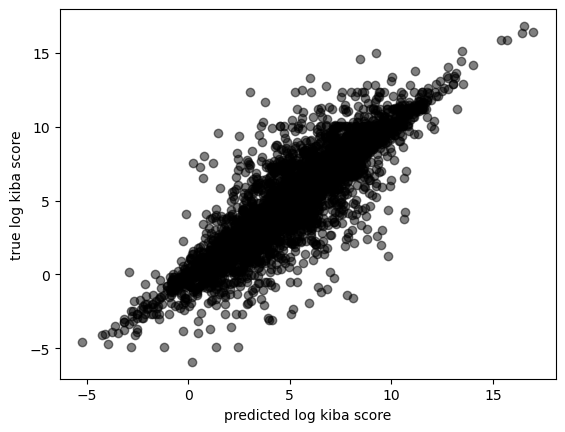

In [121]:
plt.plot(y_pred, y, 'ok', alpha=0.5)
plt.xlabel('predicted log kiba score')
plt.ylabel('true log kiba score')
plt.show()

If you insist on evaluating based on linear values.. 

In [123]:
r2_score(np.exp(y), np.exp(y_pred))

0.7989874986900678

In [124]:
mean_squared_error(np.exp(y), np.exp(y_pred))

37193233200.61083